# Introduction :

Une prévision précise du prix du logement est importante pour les futurs propriétaires, promoteurs, investisseurs, évaluateurs, évaluateurs fiscaux et autres acteurs du marché immobilier, tels que les prêteurs hypothécaires et assureurs. La prévision du prix des maisons traditionnelles est sur la base du prix de revient et de la comparaison des prix de vente. Par conséquent, la disponibilité d'un modèle de prévision du prix des logements aide à combler manque d'information important et amélioration de l'efficacité du marché immobilier.

**Dans ce notebook**,on va utiliser des techniques de machines learning pour le cas supervisé puisqu'on connait d'avance les prix des maisons. On va comparer plusieurs algorithmes et prendre le plus performant selon le critére **RMSE** qu'on va le définir. Ensuite on lui applique le peaufinage pour qu'il donne de bonne prediction.Maintenant si par malheur aucun des algorithmes qu'on a choisit n'est pas performant, alors on fera un boosting qui consiste à prendre un apprenant faible (mauvais prédicteur) et l'améliore en appliquant des techniques d'ensemble.

Bien sûr, avant d'entamer le problème on va préparer les donnés (enlever les valeurs manquantes et infinis,faire un peu de statistique descriptive et on va faire beaucoup de tests statistiques comme Z_score et ANOVA et observer les corrélations entre les attributs et leurs importances....)

## 1) Importation et inspection des données
Dans cette on va importer les données via la bibliothéque pandas et essayer de voir un peu du tableau.
Examiner la dimension du tableau(DataFrame) et faire un résumé statistique.
Verification de types de variables.
Voir numériquement les corrélation entre les variables.

In [30]:
#importation des bibliothéque nécessaire
import pandas as pd
import numpy as np

#ce module est étranger par rapport aux autres mais il va nous aider à enlever les "warnings" qui vont nous géner
import warnings
warnings.filterwarnings(action='ignore')

In [31]:
#téléchargement du fichier csv en appliquant la fonction read_csv et en précisant le séparateur
file='https://dataks.bitbucket.io/ml/housing.csv'
data=pd.read_csv('https://dataks.bitbucket.io/ml/housing.csv',sep=';')

In [32]:
#dimension des données
data.shape

(546, 13)

In [33]:
#voir quelque lignes
data.head()

,Unnamed: 0,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
0,1,42000.0,5850,3,1,2,yes,no,yes,no,no,1,no
1,2,38500.0,4000,2,1,1,yes,no,no,no,no,0,no
2,3,49500.0,3060,3,1,1,yes,no,no,no,no,0,no
3,4,60500.0,6650,3,1,2,yes,yes,no,no,no,0,no
4,5,61000.0,6360,2,1,1,yes,no,no,no,no,0,no


Il y a une colonne qui a une forme étrangère et elle n'est meme pas un variable explicative.
Il vaut mieux l'enlever pour qu'elle n'affecte pas les performances des algorithme.

In [34]:
#remplacer l'index par Unnamed et suprimation de cette derenière
data.index=data['Unnamed: 0']
del(data['Unnamed: 0'])

Maintenant on va essayer de voir le type des variables et s'il y a des données manquantes. 

In [35]:
#acquérir des informations sur nos données
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546 entries, 1 to 546
Data columns (total 12 columns):
price       546 non-null float64
lotsize     546 non-null int64
bedrooms    546 non-null int64
bathrms     546 non-null int64
stories     546 non-null int64
driveway    546 non-null object
recroom     546 non-null object
fullbase    546 non-null object
gashw       546 non-null object
airco       546 non-null object
garagepl    546 non-null int64
prefarea    546 non-null object
dtypes: float64(1), int64(5), object(6)
memory usage: 55.5+ KB


Heureusement, il n'ya pas de données manquantes et le nombre de colonnes a diminué.
On trouve un attribut de type réel et cinq de types entier.
Par contre, il y a des attributs qu'on ne connait pas exactement leur type (object peut etre une chaine de caractère par example ou tout simplement un objet spécifique à python).
On constate que la DataFrame utilise 51.3 KB.

Maintenant, on va faire un petit résumé statistique.

In [36]:
#création de résumé statistique
data.describe()

,price,lotsize,bedrooms,bathrms,stories,garagepl
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000
mean,68121.597070,5150.265568,2.965201,1.285714,1.807692,0.692308
std,26702.670926,2168.158725,0.737388,0.502158,0.868203,0.861307
min,25000.000000,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,49125.000000,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,62000.000000,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,82000.000000,6360.000000,3.000000,2.000000,2.000000,1.000000
max,190000.000000,16200.000000,6.000000,4.000000,4.000000,3.000000


On va se concentrer maintenant sur la variable à expliquer **price**. En moyenne, le prix de vente des maisons est autour de 68121. avec un écart-type de 26702.(la distance moyenne qui sépare les vrais valeurs prises par notre variable et la moyenne) qui est un écart notable mais ça ne va pas affecter la performance des algorithmes qu'on va utiliser aprés.
On constate que 25% des prix sont inférieurs à 49125. et 75% des prix sont inférieurs à 82000.

Dans cette partie, on va essayer de voir numériquement les corrélations des attributs entre eux et avec le prix(variables quantitatives seulement) en utilisant le fameux coefficient de **Pearson** et les skew (**skewness**) des attributs, autrement dit l'asymétrie dans leur distribution de probabilité (empiriquement).

In [37]:
# matrice de correlation et skewness
correlation=data.corr(method='pearson')
skewness=data.skew()

#Affichage
print(correlation)
print('________________________________________________________')
print(skewness)

             price   lotsize  bedrooms   bathrms   stories  garagepl
price     1.000000  0.535796  0.366447  0.516719  0.421190  0.383302
lotsize   0.535796  1.000000  0.151851  0.193833  0.083675  0.352872
bedrooms  0.366447  0.151851  1.000000  0.373769  0.407974  0.139117
bathrms   0.516719  0.193833  0.373769  1.000000  0.324066  0.178178
stories   0.421190  0.083675  0.407974  0.324066  1.000000  0.043412
garagepl  0.383302  0.352872  0.139117  0.178178  0.043412  1.000000
________________________________________________________
price       1.209829
lotsize     1.322758
bedrooms    0.495872
bathrms     1.592096
stories     1.074657
garagepl    0.844808
dtype: float64


On voit qu'il y a une corrélation entre le prix et les variables explicatives et une faible corrélation entre eux.
Géneralement, il faut se méfier des corrélations entre les variables explicatives puisque théoriquement en suppose que on a pris un échantillon issue d'une population qu'on ne connait pas sa loi(c.à.d qu'on ne connait pas sa probabilité de tirages des individus ou lois jointes théoriquement parlant) et la définition d'un échantillon indique les variables (attributs) doivent etre indépendantes et identiquement distribués. Donc si les variables sont fortement corrélés entre eux, alors les résultats obtenus par les algorithmes vont etre erroné. Pour l'asymétrie de distribution des attributs, si on les négliges cela va affecter les modèles linéaires puisqu'ils supposent par hypothése que les lois des variables explicatives sont distribuées suivant la loi **normal**.


## 2) Visualisation et test statistique

### Visualisation

 On va faire des visualisation statistiques en utilisant les variables catégoriques.
Par exemple, on va utiliser la variable cathégorique **driveway** pour dessiner le **boxplot** des prix si la maison admet un allée ou non leur **swarmplot** et c'est possible grace au module **seaborn**.
On peut dessiner aussi les histograms, les scatterplots et la regression linéaire entre les variables quantitatives en les séparant par une variables catégorique.

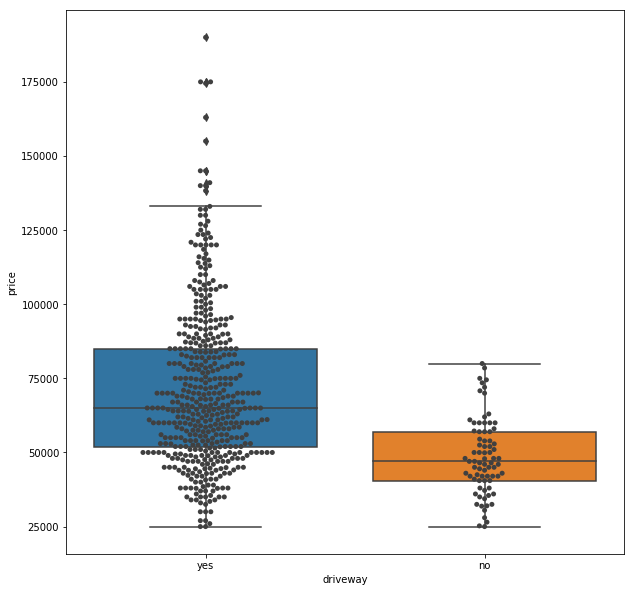

In [38]:
# importation du module seaborn et matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

#ne pas oublier "the magic word "
%matplotlib inline

#creation du boxplot et du swarmplot et les mettrent dans un meme graph
fig,ax=plt.subplots(figsize=(10,10))
sns.boxplot(data=data,y='price',x='driveway')
sns.swarmplot(data=data,y='price',x='driveway',color='.25',ax=ax)

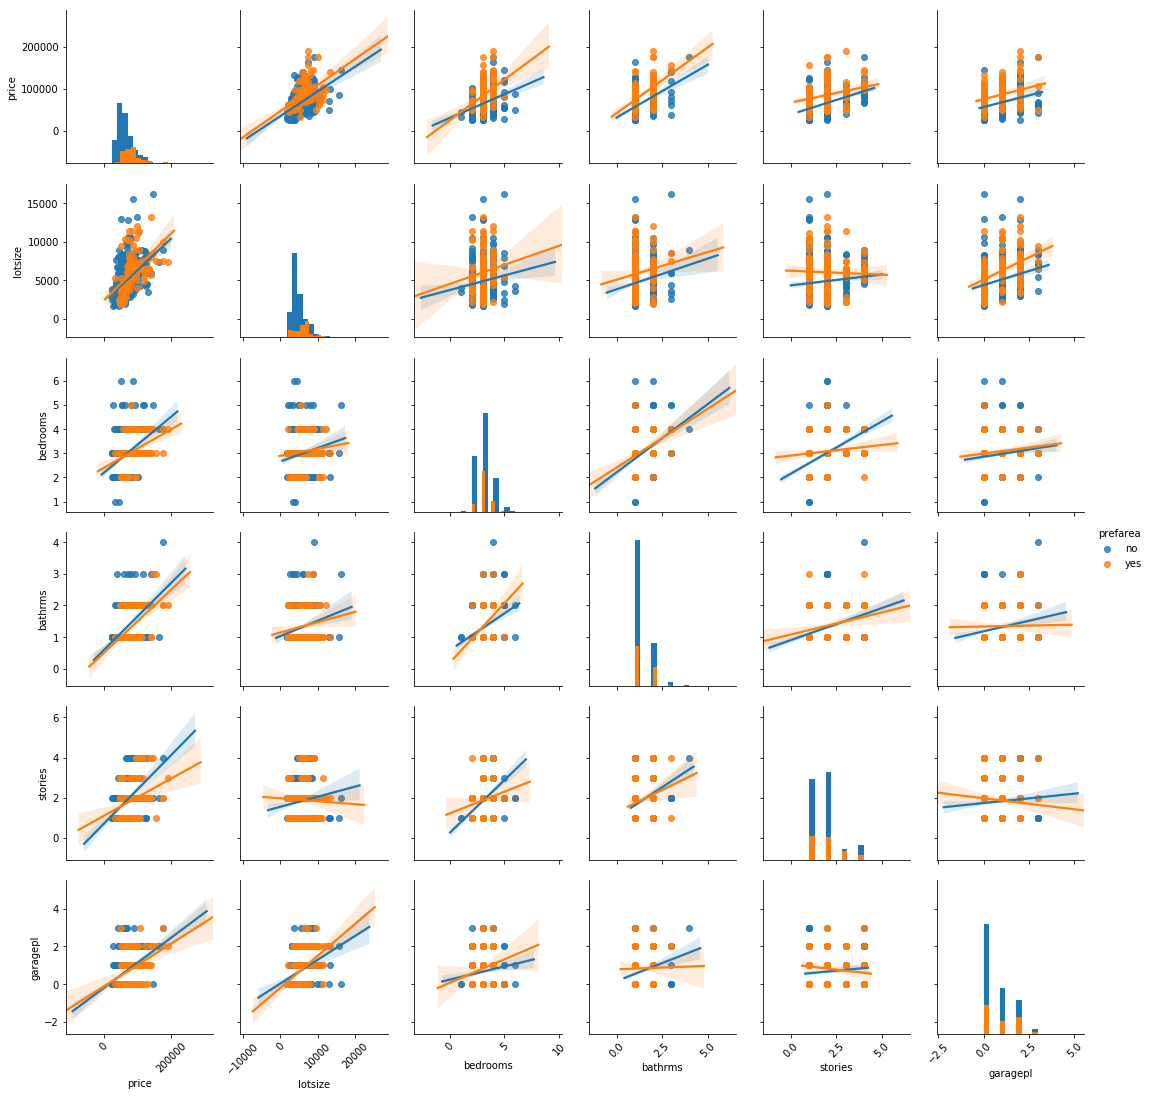

In [39]:
# creation du pairplot
g=sns.pairplot(data, hue='prefarea', diag_kind='hist',kind='reg')

#amélioration du graph
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

On peut aussi tracer les densités des variables quantitatives (on utilise des estimations pour approcher les vrais densités en utilisant les estimateurs par noyau) 

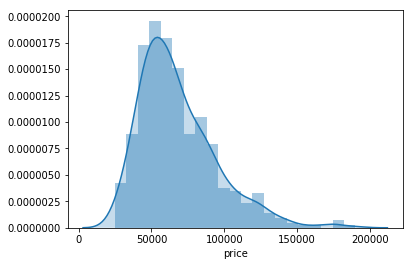

In [40]:
# traçage de densité de la  variable "price"
sns.distplot(data['price'], kde=True, rug=False, kde_kws={'shade':True})

La forme de la densté resemble beaucoup une gaussienne.
On va vérifier si c'est le cas avec le test de **student** ou le test **Anderson_Darling**


Dernièrement, on va tracer la fameuse **heatmap** qui sert à visualiser les corrélations entre les variables.

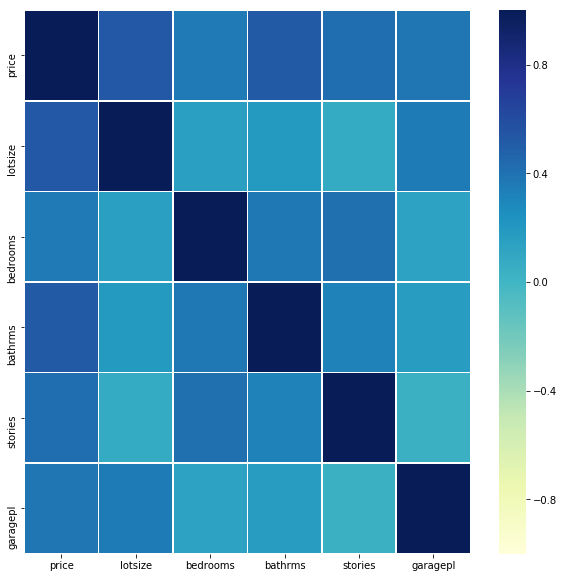

In [41]:
#cette instruction sert à faire un zoom pour la heatmap
fig,ax=plt.subplots(figsize=(10,10))

# traçage de la heatmap
sns.heatmap(correlation, vmin=-1, vmax=1,linewidth=.5,cbar=True,cmap="YlGnBu",ax=ax)

### Test statistique

Cette section est dédié au test statistique.
En particulier, on va faire un test de normalité sur la variable à expliquer **price** et des test statiques sur le modèle linéaire qu'on va créer avec nos données.


Test de normalité de student:
Le test de **student** suppose que l'échantillon est tiré suivant une loi normale et il nous permet de dire si la moyenne de la loi normale est égale à une valeur donné comme **hypothése nulle** ou non (ça marche dans le cas ou la variance 
et connue ou non).

Mais le problème est qu'on a supposé que la variable **price** suit une loi normale sans un argument pertinent, donc on va utiliser un test spécifique (test non paramétrique) pour résoudre ce probléme.

On va utiliser le test de **Shapiro-Wilk** qui teste l'hypothèse nulle selon laquelle un échantillon x1,...,xn est issu d'une population normalement distribuée.

On va alors préparer le terrain pour faire ce test.

In [42]:
#importation des modules
from scipy.stats import shapiro
from scipy.stats import zscore

# préparation des données
price=data['price'].values

#utilisation du test de Shapiro
p_value,test_statistique=shapiro(price)

#affichage des valeurs
print('p_valeur ', p_value)
print('statistique de statistique ', test_statistique)

p_valeur  0.9220566749572754
statistique de statistique  3.3822067935511575e-16


D'abord, on va définir la notion de p_valeur.

la p_valeur est la probabilité pour un modèle statistique donné sous l'hypothèse nulle d'obtenir la même valeur ou une valeur encore plus extrême que celle observée.

C'est à dire, on suppose que notre hypothése nulle est vrai puis on calcule la probabilté d'une observation donné **sachant H0 est vrai**.

Si la probabilité est faible, c'est un signale qui nous indique que l'hypothése qu'on a supposé vrai **peut etre irroné** mais ça ne veut pas dire qu'on va la rejété directement.C'est pour cela qu'on définit généralement un seuil (0.05).

Donc le résulat est > à 0.05.Donc notre supposition est vrai c.à.d la variable **price** à pour distribution une loi normale.


Dans cette partie on va créer un modéle linéaire classique sans utiliser le module **sklearn**.
Pour appliquer le modéle à nos données, il faut bien les préparer.

In [43]:
# transformation des variables catégoriques en entier
data1=pd.get_dummies(data)

# voir les columns
data1.columns

# sneak peek
data1.head()

# changer les noms des columns
data1.rename(columns={'driveway_yes':'driveway','recroom_yes':'recroom','fullbase_yes':'fullbase','gashw_yes':'gashw','airco_yes':'airco','prefarea_yes':'prefarea'},inplace=True)
data1.columns

''' la méthode get dummies transforme les variables yes/no en 0/1 et elle crée une sorte de réplication c.à.d si on prend
    exemple l'attribut recroom_yes valant 1 alors recroom_no vaut 0.Donc ça va crée une forte corrélation et il faut impérativement
    les élimner. '''
data2=data1.drop(['driveway_no','recroom_no','fullbase_no','gashw_no','airco_no','prefarea_no'],axis=1)
data2.head()

#on va changer les type unint en int64 en créant
names=['lotsize','bedrooms','bathrms','stories','garagepl','driveway','recroom','fullbase','gashw','airco','prefarea']
for i in names:
    data2[i]=data2[i].apply(pd.to_numeric)
    
# vérification
print(data2.dtypes)
print(data2.shape)

# on enléve les valeurs abérante avec le test z_score
z = np.abs(zscore(data2))
print(z)

# on fait le test 
data3=data2[(z<3).all(axis=1)]
data3.shape

price       float64
lotsize       int64
bedrooms      int64
bathrms       int64
stories       int64
garagepl      int64
driveway      int64
recroom       int64
fullbase      int64
gashw         int64
airco         int64
prefarea      int64
dtype: object
(546, 12)
[[0.97913617 0.32302806 0.0472349  ... 0.21905398 0.68103375 0.55337157]
 [1.11032939 0.53101296 1.31014696 ... 0.21905398 0.68103375 0.55337157]
 [0.69800783 0.96495812 0.0472349  ... 0.21905398 0.68103375 0.55337157]
 ...
 [1.30737434 0.39227462 0.0472349  ... 0.21905398 1.46835601 0.55337157]
 [1.3823419  0.39227462 0.0472349  ... 0.21905398 1.46835601 0.55337157]
 [1.3823419  0.39227462 0.0472349  ... 0.21905398 1.46835601 0.55337157]]


(500, 12)

Donc avec cette procédure on a perdu pas mal de donnée puisque à la base on a pas beacoup mais il vaut mieux les enlever que de les laisser falcifier nos résultats.

Maintenant on va appliquer le modéle linéaire.

In [44]:
# importation des modules
import statsmodels.api as sm

# préparation des données
X=data3.drop('price', axis=1).values
y=data3['price']

# on ajoute l'intercept à notre modéle
X=sm.add_constant(X)

# création du modéle et estimation
model = sm.OLS(y, X).fit()

# affichage des résultats statistiques
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     100.1
Date:                Wed, 27 Feb 2019   Prob (F-statistic):          1.64e-111
Time:                        05:38:45   Log-Likelihood:                -5459.2
No. Observations:                 500   AIC:                         1.094e+04
Df Residuals:                     489   BIC:                         1.099e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2433.5433   3348.885      0.727      0.4

On voit que le modéle linéaire n'est pas prometteur puisqu'on nous affiche un message **warnings** que la matrix X n'est pas inversible ce qui veut dire qu'il y a des corrélation entre les attributs.

On va calculer à nouveau la matrice de corrélation et voir la heatmap.

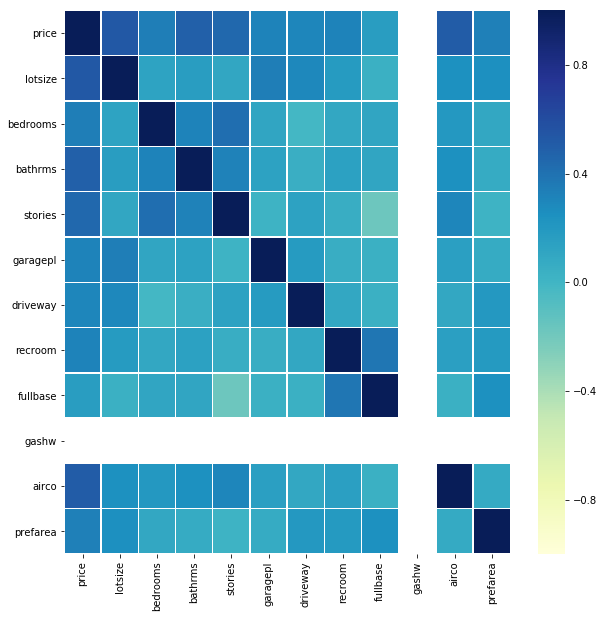

In [45]:
# matrice de covariance
corr2=data3.corr(method='pearson')

#cette instruction sert à faire un zoom pour la heatmap
fig,ax=plt.subplots(figsize=(10,10))

# traçage de la heatmap
sns.heatmap(corr2, vmin=-1, vmax=1,linewidth=.5,cbar=True,cmap="YlGnBu",ax=ax)

Ce qu'il parait il ya un truc qui ne va pas avec la variable **gashw**. Apparament elle que la valeur 0 et parsuite c'est la peine de la garder. On va vérifier maintenant.

In [46]:
# on compte le nombre des instances qui ont pour gashw=0
data3[data3['gashw']==0].count()

price       500
lotsize     500
bedrooms    500
bathrms     500
stories     500
garagepl    500
driveway    500
recroom     500
fullbase    500
gashw       500
airco       500
prefarea    500
dtype: int64

Effectivement, il faut enlever cette ou sois on change des valeurs par 1 aléatoirement mais c'est pas pratique.

In [47]:
# enlévement de la colonne gashw
data4=data3.drop('gashw',axis=1)

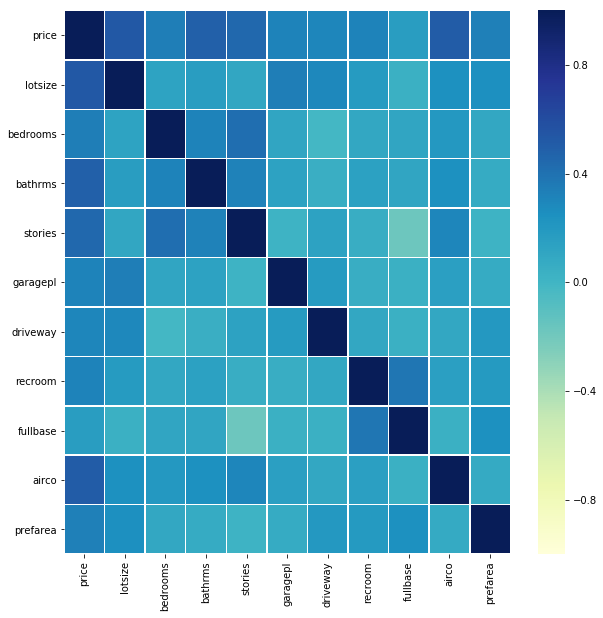

In [48]:
# matrice de covariance
corr3=data4.corr(method='pearson')

#cette instruction sert à faire un zoom pour la heatmap
fig,ax=plt.subplots(figsize=(10,10))

# traçage de la heatmap
sns.heatmap(corr3, vmin=-1, vmax=1,linewidth=.5,cbar=True,cmap="YlGnBu",ax=ax)

On applique le modéle linéaire sur nos nouveaux données préparer.

In [49]:
# préparation des données
X=data4.drop('price', axis=1).values
y=data4['price']

# on ajoute l'intercept à notre modéle
X=sm.add_constant(X)

# création du modéle et estimation
model = sm.OLS(y, X).fit()

# affichage des résultats statistiques
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     100.1
Date:                Wed, 27 Feb 2019   Prob (F-statistic):          1.64e-111
Time:                        05:38:47   Log-Likelihood:                -5459.2
No. Observations:                 500   AIC:                         1.094e+04
Df Residuals:                     489   BIC:                         1.099e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2433.5433   3348.885      0.727      0.4

Normalement il n'y a pas de forte corrélation entre les covariables mais dans tous les cas on va utiliser d'autre algorithme dans la partie à suivre.

## 3) Modélisation de probléme

Dans cette partie on va utiliser des méthodes de regressions (algorithmes de prédiction pour le cas des variables à expliquer) et comme énoncé dans l'introduction, on essaye de prédire le prix avec des techniques plus sophistiqué.

Mais le c'est qu'on ne sait qu'elle algorithme va etre le plus performant.
Déja on sait que le modéle linéaire classique **OLS** n'est pas vraiment à la hauteur de ce probléme.
Peut étre qu'il faut utiliser qui régularise à chaque itération comme **ridge**, **lasso**et **elastic-net**.

Bien sûr, on doit définir c'est quoi exactement la **régularisation** en machine learning.
La régularisation est tout simplement un mécanisme permettant de minimiser le surapprentissage en pénalisation certaines atrributs celon un critère spécifique.

On peut aussi utiliser d'autre modéle non linéaire comme le support vector machine **SVM** qui est basé sur les noyaux et les séparations par des hyperplans et les séparateurs à vastes marges et les arbres de décisions connus par leur simplicité et efficacité que ce soit pour les problémes de régression ou classification.

Dérniérement, comment évaluer la performance des modéles? Qu'elle critére d'évaluation choisir?
Le critére d'évaluation qu'on va utiliser est l'espérance de cout quadratique connue sous le nom **RMSE**et on va le définir.

À la fin de l'évaluation, on prendra le modéles le plus performant et on l'améliore avec le **Hypertuning**.

### Encore de préparation

Dans cette section on va enlever les skew (asymétrie) des attributs en utilisant des fonctions mathématiques comme le **logharithme** et la fonction **cubic** pour améliorer la performance des algorithmes.
Ensuite, on va définir notre critére d'évaluation **RMSE**.
Il faut faire attention à l'apparition des valeurs **inf** car aucun alghorithmes de machine learning ne va fonctionner s'ils sont présent.

In [50]:
# définir la fonction x**3
def cubic(X):
    return X**3

#définr la fonction RMSE
def my_loss_function(y_test,y_predict):
    return np.sqrt(np.mean(y_test-y_predict)**2)

# application des fonctions qui vont enlever les asymétries
data4['price'].apply(np.log)
data4['lotsize'].apply(np.log)
data4['bathrms'].apply(np.log)
data4['stories'].apply(np.log)
data4['garagepl'].apply(cubic)

# vérifier si les inf existent
unsk_price=data4['price'].apply(np.log)
unsk_lotsize=data4['lotsize'].apply(np.log)
unsk_bathrms=data4['bathrms'].apply(np.log)
unsk_stories=data4['stories'].apply(np.log)
unsk_garagepl=data4['garagepl'].apply(cubic)
liste=[unsk_price,unsk_lotsize,unsk_bathrms,unsk_stories,unsk_garagepl]
for i in liste:
    #test si les inf existent
    inf_values=np.isinf(i)
    unique,counts=np.unique(inf_values, return_counts=True)
    # les mettre dans un dictionnaire
    print(dict(zip(unique,counts)))

{False: 500}
{False: 500}
{False: 500}
{False: 500}
{False: 500}


Avant d'entamer la résolution du probléme, on va découper nos données en deux ensembles (on l'appelle **hold out validation dataset** ).
le premier sert à évaluer les modéles et prendre le plus performant.
le second (on l'appelle **hold out validation dataset** ) vérifie si il n'y a pas de contradiction dans les résultats.

In [51]:
# importation de module nécessaire
from sklearn.model_selection import train_test_split

#transformation des données en des matrices
X1=data4.drop('price', axis=1).values
y1=data4['price'].values

# découpage des données
X_train,X_validation,y_train,y_validation=train_test_split(X1,y1,test_size=0.2,random_state=42)

## Modélisation

Téléchargement des modules nécessaires pour aborder le probléme.

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings(action='ignore')

Pour la modélisation, on a déja bien préparer les données et il nous manque juste la normalisation des données qu'on va le faire en utilisant les pipelines.
Les pipelines font deux taches en une seules ligne, ce qui va nous faciliter la vie.
On va utiliser la validation vroisé pour minimiser le risque de surapprentissage.
À la fin, on choisit le meilleur modéles pour lui booster par un tuning et ensuite le valider.

In [53]:
# pour pouvoir calculer la performance à chaque validation croisé dans val_cross_score
my_score=make_scorer(my_loss_function,greater_is_better=True)

# transformer ridge, lasso et elasticnet en des regresseur polynomiaux
poly=PolynomialFeatures(degree=4,include_bias=False)

# création d'une liste qu'on va utiliser dans la validation croisé pour calculer la moyenne des performances
pipelines=[]

#instantiation des pipelines
pipelines.append(('scaledRD',Pipeline([('Scaler',StandardScaler()),('RD',Ridge())])))
pipelines.append(('scaledLS',Pipeline([('Scaler',StandardScaler()),('LS',Lasso())])))
pipelines.append(('scaledEN',Pipeline([('Scaler',StandardScaler()),('EN',ElasticNet())])))
pipelines.append(('scaledDT',Pipeline([('Scaler',StandardScaler()),('DT',DecisionTreeRegressor())])))
pipelines.append(('scaledKNNR',Pipeline([('Scaler',StandardScaler()),('KNNR',KNeighborsRegressor())])))
pipelines.append(('scaledSVR',Pipeline([('Scaler',StandardScaler()),('SVR',SVR())])))
pipelines.append(('polyScaledRD',Pipeline([('Scaler',StandardScaler()),('polynome',poly),('RD',Ridge())])))
pipelines.append(('polyScaledLS',Pipeline([('Scaler',StandardScaler()),('polynome',poly),('LS',Lasso())])))
pipelines.append(('polyScaledELS',Pipeline([('Scaler',StandardScaler()),('polynome',poly),('ELS',ElasticNet())])))

# Porteuse des résultats et noms pour pouvoir les affichées ensemble
resultats=[]
noms=[]

# parcour de la liste
for nom,model in pipelines:
    
    #instansiation de la validation croisé
    lv=KFold(n_splits=10, random_state=42)
    
    # performances des modéles
    resultat=cross_val_score(model,X_train,y_train,cv=lv,scoring=my_score)
    
    # mettre les résultats et les noms dans les listes
    noms.append(nom)
    resultats.append(resultat)
    
    #affichages
    msg='%s: %f '%(nom, resultat.mean())
    print(msg)

scaledRD: 2222.262096 
scaledLS: 2220.130470 
scaledEN: 2540.450270 
scaledDT: 2824.430833 
scaledKNNR: 1852.597500 
scaledSVR: 5897.323864 
polyScaledRD: 6596.306727 
polyScaledLS: 10065.376547 
polyScaledELS: 2878.410898 


On voit que KNN est le plus performant. Donc il sera notre candidats pour le tuning.

In [54]:
# configuration de la grille
param_grid={'n_neighbors':np.arange(1,50)}

# creation de modéle
knn=KNeighborsRegressor()

# tuning du modele
knn_cv=GridSearchCV(knn, param_grid, cv=5)

# Addaptation aux données
knn_cv.fit(X_train, y_train)

# Affichage meilleur score et meilleur paramétre
print("Best parameters found: ", knn_cv.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(knn_cv.best_score_)))

Best parameters found:  {'n_neighbors': 49}
Lowest RMSE found:  0.5744582769790424


On voit que pour **n=49**, le modéle ne se trompe presque jamais.
Espérons que c'est vraiment le cas.

In [55]:
# préparation du modéle
normalisateur=StandardScaler().fit(X_train)
X_normaliser=normalisateur.transform(X_train)
knn=KNeighborsRegressor(n_neighbors=49)
knn.fit(X_normaliser, y_train)

#transformer l'ensemble de validation
XValidationnormaliser=normalisateur.transform(X_validation)

# faire des prédiction
predictions=knn.predict(XValidationnormaliser)

#afficher le résultat
print(my_loss_function(y_validation, predictions))

3236.899795918367


Voila, personellement c'était prévisible déja le message qu'on on a reçu en adoptant le modéle linéaire était un peu louche.
Donc la valeur de la performance de knn est **3236.899** qui n'est pas mal mais on peut faire mieux.


## XGBOOST ET BOOSTING

**XGBOOST** est un algorithme  écrit à l'origine en C ++, il est comparativement plus rapide que les autres classificateurs d'ensemble.

il a montré de meilleures performances sur divers jeux de données de référence d’apprentissage automatique c.à.d on a pas besoin de comprendre d'où vient le probléme de nos données, il suffit de lui donner n'importe qu'elle donner il va la transformer de façon à optmiser la performance de l'algorithme.

XGBoost possède en interne des paramètres de validation croisée, de régularisation, de fonctions d’objectif définies par l’utilisateur, de valeurs manquantes, de paramètres d’arbre, d’API compatibles scikit-learn.

Le **boosting** est une technique séquentielle qui fonctionne sur le principe d'un ensemble. Il combine un ensemble d’apprenants faibles et offre une précision de prévision améliorée.

On va voir si on va obtenir un résultat meilleur que le **KNN**.

In [60]:
# importation des modules nécessaires
import xgboost as xgb

# Instantiation de régresseur
xg_reg2 = xgb.XGBRegressor(objective="reg:linear", n_estimators=100, max_depth=10)

# Adapter les données
xg_reg2.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds2 = xg_reg2.predict(X_validation)

# Compute the rmse: rmse
rmse =  my_loss_function(y_validation,preds2)
print("RMSE: %f" % (rmse))

RMSE: 374.338398


In [ ]:
On va utiliser un boosting linéaire.

In [62]:
DM_train=xgb.DMatrix(data=X_train,label=y_train)
DM_test=xgb.DMatrix(data=X_validation,label=y_validation)

params={'booster':'gblinear','objective':'reg:linear','alpha':1}
# Train the model: xg_reg
xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=200)

# Predict the labels of the test set: preds
preds = xg_reg.predict(DM_test)

# Compute and print the RMSE
rmse = my_loss_function(y_validation,preds)
print("RMSE: %f" % (rmse))


RMSE: 683.439883


On a obtenu un meilleur résultat que **KNN** sans utilisation de la technique de validation croisé ni tuning.
Donc je pense que ce modéle est le plus prometteur.


# Conclusion

Je pense qu'on utilisant le boosting on résout non seulement le problémes des données un peu spéciale mais on peut aussi optimiser le temps de calcule et on peut meme l'appliquer dans des probléme à grande dimension.